###### Michael Green, Xiaobo Chen | University of Missouri-Kansas City


---

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

questions regarding implementation can be directed towards magwwc@mail.umkc.edu or chenxiaobo@umkc.edu



---

About this Notebook:
---

This jupyter notebook is curtailed to run within the Google colab cloud computing environment. While many of the concepts related to the Python programming language are available cross-platform, some of the functionality of this specific jupyter notebook is tethered to the google.colab module. Thus, some of the features of  this notebook (mainly, the method for importing data into the cloud) may not be available outside of the google.colab cloud computing environment.

How to use:
---

This `jupyter notebook` contains little boxes called cells. Each cell contains either text (like this cell) or `code` (like the next cell). In order to use this notebook for your GC calculations, you will need to run each cell in the order which they appear*. If everything goes well, you should see a set of graphs at the end of this notebook.

When using this notebook for your own work, there are two cells which will require your input. These are marked at the top with the test `# USER INPUT #` surrounded by hash marks. Be particularly sure to pay attention to those cells.

To start, a bit of semantics: The `#` hash marks a comment string in Python, and text after the hash is not interpreted as code.

    * There is an optional cell which can be skipped.

In [0]:
### OPTIONAL CELL ###

# This cell is for demo use. 

# Run this cell (or select 'Run all' under the 'Runtime tab above to run every 
# cell') to grab data from the internet as a demo. 

# When the demo is complete, under the tab 'Runtime' at the top of the screen, 
# click 'Restart Runtime', then click 'yes'. This will reset the notebook so 
# you can upload your own data.

uploaded = [
    'https://tinyurl.com/JCEpyGC1to1'
]

demo = True

In [0]:
# import the various tools that we'll use

import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.integrate import quad

In [0]:

################################## USER INPUT ################################## 

# running this box will prompt a button which contains the label 
# 'Choose Files'. Press this button and navigate to the .csv file you wish
# to use for calculation. Only select a single file.

# this 'if' statement is just a check to see if the demo was run
if 'demo' not in locals():
    uploaded = files.upload()

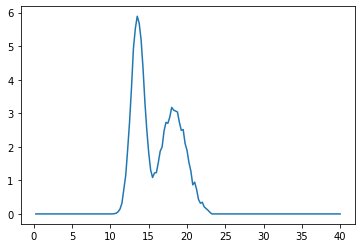

In [10]:
# uses a library called pandas (pd) to format our data into a Nx2 numpy array.
for upload in uploaded:
    data_set = pd.read_csv(upload).to_numpy()

plt.plot(data_set[:,0], data_set[:,1])

In [0]:

################################## USER INPUT ##################################

# initial guess for gaussian distributions to optimize 
# [height, position, width]. If more than 2 distributions are required, 
# add a new set of [h,p,w] initial parameters to 'initials' for each new 
# distribution, for each file. New parameters should be of the same
# format for consistency.

#        peak1    peak2    peak3
# i.e. [[h,p,w], [h,p,w], [h,p,w], ...] etc. 
# A 'w' guess of 1 is typically a sufficient estimation.

initials = [
    [4.5, 13, 1],
    [2.5, 19, 1]
]

n_value = len(initials)


In [0]:
# defines a typical gaussian function, of independent variable x,
# amplitude a, position b, and width parameter c.
def gaussian(x,a,b,c):
    return a*np.exp((-(x-b)**2.0)/c**2.0)

# defines the expected resultant as a sum of intrinsic gaussian functions
def GaussSum(x, p, n):
    return sum(gaussian(x, p[3*k], p[3*k+1], p[3*k+2]) for k in range(n))

# defines condition of minimization, called the resudual, which is defined
# as the difference between the data and the function.
def residuals(p, y, x, n):
    return y - GaussSum(x,p,n)  

In [0]:
# using least-squares optimization, minimize the difference between the data
# provided by experiment and the curve used to fit the function.

cnsts =  leastsq(
            residuals, 
            initials, 
            args=(
                data_set[:,1],          # y data
                data_set[:,0],          # x data
                n_value                 # n value
            )
        )[0]


In [0]:
# integrates the gaussian functions through gauss quadrature and saves the 
# results to a list, and each list is saved to its corresponding data file 
# in the empty 'area_sets' dictionary.

areas = dict()

for i in range(n_value):
    areas[i] = quad(
        gaussian,
        data_set[0,0],      # lower integration bound
        data_set[-1,0],     # upper integration bound
        args=(
            cnsts[3*i], 
            cnsts[3*i+1], 
            cnsts[3*i+2]
        )
    )[0]


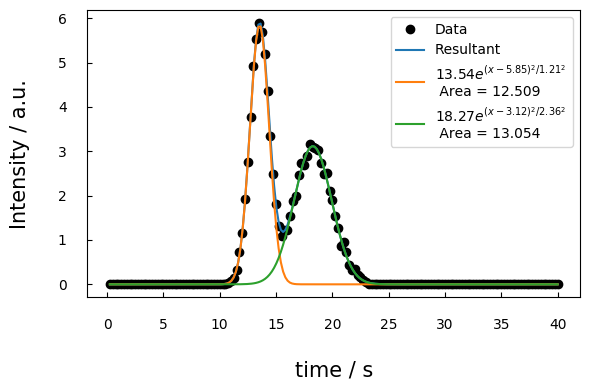

In [17]:
# this is all just building graphs with the results.


# defines the independent variable. 
x = np.linspace(data_set[0,0],data_set[-1,0],200)

fig, ax = plt.subplots(dpi = 100)

#sets the axis labels and parameters.
ax.tick_params(direction = 'in', pad = 15)
ax.set_xlabel('time / s', labelpad = 20, fontsize = 15)
ax.set_ylabel('Intensity / a.u.', labelpad = 20, fontsize = 15)

# plots the first two data sets: the raw data and the GaussSum.
ax.plot(data_set[:,0], data_set[:,1], 'ko')
ax.plot(x,GaussSum(x,cnsts, n_value))

# adds a plot of each individual gaussian to the graph.
for i in range(n_value):
    ax.plot(
        x, 
        gaussian(
            x, 
            cnsts[3*i], 
            cnsts[3*i+1], 
            cnsts[3*i+2]
        )
    )


# creates ledger for each graph
ledger = ['Data', 'Resultant']
for i in range(n_value):
    ledger.append(
        str(round(cnsts[3*i+1], 2)) + 
        '$e^{(x-' + str(round(cnsts[3*i], 2)) + 
        ')^2 / ' + str(round(cnsts[3*i + 2], 2)) + 
        '^2}$' + ' \n Area = ' + str(round(areas[i], 3))
    ) 

#adds the ledger to the graph.
ax.legend(ledger)

# format and show
plt.tight_layout()
plt.show()